## Exercise 1

Lirong Ma, Catherine Yang

### BabyNames Class

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

class BabyNames():


    def __init__ (self, path):
        
        """
        The constuctor for BabyNames class
        
        Parameters:
            path : the file location to create Pandas DataFrame
            
        """
    
        columns = ['state', 'sex', 'year', 'name', 'num']
        
        self.df = pd.concat(
            [pd.read_csv(f, names = columns) for f in glob.glob(path+"*.TXT")],
            ignore_index = True,
            sort = False
        )
              
        
    def count(self, state = None, year = None):
    
        """
        The function to count the total number of births for a given state and year
        
        Parameters:
            state (optional) : a given state name. If it is None, count the total number of births for all states.
            year (optional) : a given year. If it is None, count the total number of births for all years.

        Returns:
            total number of births in a given state and year
        """
    
        data = self.df
        
        if (state == None) and (year == None):
            return data['num'].sum()
        elif state == None:
            return data[data.year == year].num.sum()
        elif year == None:
            return data[data.state == state].num.sum()
        else:
            return data[(data.year == year) & (data.state == state)].num.sum()

 
    def Top10BabyNames(self, state = None, year = None):

        """
        The function to find top 10 female and male baby names in a given state and a given year

        Parameters:
            state (optional) : a given state name. If it is None, consider the total number of births for all states.
            year (optional) : a given year. If it is None, consider the total number of births for all the years.

        Returns:
            result : a dataframe that contains top 10 female and male baby names 
        """
        
        data = self.df
        
        if (state is not None):
            data = data[data.state == state]

        if (year is not None):
            data = data[data.year == year]
        
        # "num" becomes the only column containing numeric data
        # when we use sum(), it will only show the sum of "num"
        
        # sum num and sort in descending order for female and male separately
        female = data[data.sex == 'F'].groupby('name').sum().reset_index().sort_values(by='num', ascending = False).head(10)
        male = data[data.sex == 'M'].groupby('name').sum().reset_index().sort_values(by='num', ascending = False).head(10)
        
        # combine results and save them in a data frame
        ranklst = list(range(1,11,1))
        femalelst = female['name'].tolist()
        malelst = male['name'].tolist()

        result = pd.DataFrame(list(zip(ranklst, malelst, femalelst)), columns = ['Rank', 'Male', 'Female'])  
        result = result.style.hide_index()

        return result
    
    
    def ChangeOfPopularity(self, fromYear=None, toYear=None, top=None):
        
        """
        The function prints three lists of baby names (male or female) that increased, decreased, 
        or stayed the same in popularity.

        Parameters:
            fromYear (optional) : a given starting year for the comparison. The default is the first year in the dataset 
            toYear (optional) : a given ending year for the comparison. The default is the last year in the dataset
            top (optional): a size of the three lists need to be returned. The default is 10.
            
        Returns:
            [increasinglst, decreasinglst, samelst] 
            increasinglst: a list of baby names that increased in popularity 
            decreasinglst: a list of baby names that decreased in popularity 
            samelst: a list of baby names that had the same popularity 
        """
        
        data = self.df
        
        # set parameters to default values if they are None
        if fromYear is None:
            fromYear = data.sort_values(by='year', ascending = True)['year'].values[0]

        if toYear is None:
            toYear = data.sort_values(by='year', ascending = False)['year'].values[0]
            
        if top is None:
            top = 10
        
        # aggregate num by year for each name
        pivot = data.pivot_table('num', index = 'name', columns = 'year', aggfunc = sum)
        data = pd.DataFrame(pivot.to_records())
        fromYear=str(fromYear)
        toYear=str(toYear)
        # keep values only for fromYear and toYear
        data = data[['name', fromYear, toYear]]
        # create a column to calculate percentage change between the two years
        # perchange in num = (toYear - fromYear)/fromYear*100
        data['perchange'] = np.nan

        # only consider names which have at least one birth in both fromYear and toYear
        # if there are no births in either fromYear or toYear, percentage change is NaN
        data.loc[(np.isnan(data[fromYear]) == False) & (np.isnan(data[toYear]) == False), 'perchange'] = (data[toYear] - data[fromYear]) / data[fromYear] * 100

        data = data.loc[np.isnan(data['perchange']) == False].reset_index().sort_values(by='perchange', ascending = False)
        
        increasing = data.head(top)
        increasinglst = list(increasing.name) 

        decreasing = data.tail(top)
        decreasinglst = list(decreasing.name) 

        same = data.loc[data['perchange'] == 0].head(top)
        samelst = list(same.name)

        print("Names that increased in popularity:\n", increasinglst)
        print("Names that decreased in popularity:\n ", decreasinglst)
        print("Names having the same popularity (excluding names having no occurrences both in fromYear and toYear):\n ", samelst)

        return [increasinglst, decreasinglst, samelst]

    
    def Top5NamesPerYear(self, year = None, sex = None):
                
        """
        The function returns a data frame that shows the five most frequent given names, by state, for male, female, 
        or both in a given year. The number to the right of each name is the number of occurrences in the data.

        Parameters:
            year (optional) : aggregating the number of occurrences for the given year. 
                              If it is None, consider all the years in the dataset.
            sex (optional) :  aggregating the number of occurrences for the given sex.
                              If it is None, consider both female and male occurrences.
            
        Returns:
            result : a data frame that shows the five most frequent given names, by state, for male, female, or both 
                     in a given year.
        """
        
        data = self.df
        
        if sex is not None:
            data = data[data['sex']==sex]
            
        if year is not None:
            data = data[data['year']==year]
        
        # after subsetting, year is no longer needed 
        data = data.drop(columns="year")
        # aggregate num for each name in each state
        pivot = data.pivot_table('num', index = 'name', columns = 'state', aggfunc = sum)
        data = pd.DataFrame(pivot.to_records())
        
        states = []
        names = []
        nums = []
        
        # create a data frame to build the table needs to be returned
        result = pd.DataFrame(columns=['State', 'Rank 1', 'Num 1', 'Rank 2', 'Num 2', 'Rank 3', 'Num 3', 
                                       'Rank 4', 'Num 4', 'Rank 5', 'Num 5'])
        
        # loop through columns (states) 
        for (columnName, columnData) in data.iteritems():
            
            # skip the 'name' column (which contains all the names in the dataset)
            if columnName != 'name':
                
                # get the top 5 names and occurrences for each state
                tmp = data.nlargest(5, columnName).reset_index()
                names = tmp['name'].tolist()
                nums = tmp[columnName].values

                result = result.append(pd.Series([columnName, names[0], nums[0], names[1], nums[1], 
                                                  names[2],nums[2], names[3], nums[3], names[4], nums[4]],
                                                index=result.columns), ignore_index=True)
                
        # format the caption for the data frame
        if year is None:
            year = "All Years"
        else:
            year = str(year)
            
        if sex is None:
            sex = "Female and Male"
        elif sex == 'F':
            sex = "Female"
        else:
            sex = "Male"
        
        result = result.style.hide_index().set_caption('Top Five %s Names for Births in %s' %(sex, year))
        
        return result
    
    
    def add_prop(self, group):
        
        """
        The function calculates the proportion of occurrences for each name 

        Parameter:
            group : a data frame where a proportion column needs to be added
            
        Returns:
            group : a data frame where a proportion column has been added
        """
        group['prop'] = group.num / group.num.sum()
        return group

    
    def NamePopularityPlot(self, name = None, yearRange = None, state = None, sex = None):
        
        """
        The function creates a plot that shows the name popularity changes over the year. 
        (popularity is based on the proportional use of the name within a state and a year)
        
        Parameters:
            name (optional): a given name for the popularity plot. The default is the first name in the datset.
            yearRange (optional): a given year range for the plot. The default is the maximum year range in the dataset. 
            state (optional): a given state within which the proportional use of the name needs to be plotted.
                              If it is None, calculate the proportional use in all states.
            sex (optional): only names associated with the given sex are considered. 
                            If it is None, both females and males are considered. 
        """
        data = self.df
        
        if name is None:
            name = data['name'][0]
        
        if state is not None:
            data = data[data.state == state]
        
        if sex is not None:
            data = data[data.sex == sex]
            
        if yearRange is None:
            tmp = data.sort_values(by = 'year', ascending = True)
            fromYear = tmp.head(1)['year'].values[0]
            toYear = tmp.tail(1)['year'].values[0]
            yearRange = (fromYear, toYear)
       
        # add a column for the proportion use of the name within a state and a year
        data = data.groupby(['state','year']).apply(self.add_prop)
        data = data[(data.name == name) & (data.year <= yearRange[1]) & (data.year >= yearRange[0])]
        data = data.pivot_table('prop', index = 'year', columns='name', aggfunc = sum)
        
        data.plot(title = 'Changes of Name Popularity over Years', figsize=(12,6))
            
            
    def NameFlip(self, n=None):
        
        """
        The function lists top n names that flipped over the years.
        
        A name flip is defined as a name changed from a girl name to a boy name or the reverse 
        in two consecutive years in the dataset. Please note a name might not have occurrences
        in some years, so the difference between two consecutive years in the dataset is not
        necessarily one. For example, 1980 and 1983 might be two consecutive years for a name, 
        since nobody was given the name in 1981 and 1982.
        
        A name is counted as a girl name in a year if female occurrences > male occurrences. 
        A name is counted as a boy name in a year if female occurrences <= male occurrences.
        
        Parameters:
            n (optional): the number of rows returned. The default is 10.
            
        Returns:
            result: a data frame which lists top n names that flipped over the years
        """
        
        if n is None:
            n = 10
        
        # group by name and year and aggregate sum of occurrences for each sex
        # fill missing values with 0
        data=self.df.groupby(['name','year','sex']).sum().unstack().reset_index().fillna(0)
        data.columns = ['name','year', 'F', 'M']
        # for each name, calculate the proportion of females who were given the name
        data['prop']=data['F']/(data['F']+data['M'])
        
        # dominant = 0 if a name is a girl name (female occurrences > male occurrences)
        # dominant = 1 if a name is a boy name  (female occurrences <= male occurrences)
        data.loc[data['prop'] > 0.5, 'dominant'] = 0
        data.loc[data['prop'] <= 0.5, 'dominant'] = 1
        data.sort_values(['name', 'year'], ascending=[True, True], inplace=True)
        
        # create a data frame to keep results
        result = pd.DataFrame(columns=('name', 'flips'))
        
        # get rid of names which were used by only females or only males over the years
        # calculate average dominant(binary) for each name
        # if average == 1, the name has only been used by males
        # if average == 0, the name has only been used by females
        pivot = data.pivot_table('dominant', index='name', aggfunc = np.mean)
        pivotdf = pd.DataFrame(pivot.to_records())
        subset = pivotdf[(pivotdf.dominant != 0) & (pivotdf.dominant != 1)]
        
        # get a list of names which have been used by both females and males
        names = subset['name'].unique()
        
        for name in names:
            nflips = 0
            # get a subset of data for the name
            namesubset = data[data.name == name]
            
            # loop through each row which corresponds to each year
            # compare each year with the year after
            for i in range(len(namesubset)-1):
                if namesubset.iloc[i]['dominant'] != namesubset.iloc[i+1]['dominant']:
                    nflips += 1
             
            result = result.append({'name': name, 'flips': nflips}, ignore_index=True)
    
        # sort results by # of name flips and get top n 
        result = result.sort_values(by='flips', ascending = False).head(n)
       
        names = result['name'].tolist()
        
        # get the subset of data for names which have top n name flips
        # for each name, plot the proportion of females given the name over years
        subset = data[data.name.isin(names)]
        pivot = subset.pivot_table('prop', index = 'year', columns='name', aggfunc = sum)          
        pivot.plot(title = 'Changes of Name Popularity over Years', figsize=(15,10))
        
        return result
        
        

### A story from the Baby Names dataset

In [2]:
names=BabyNames('namesbystate/')

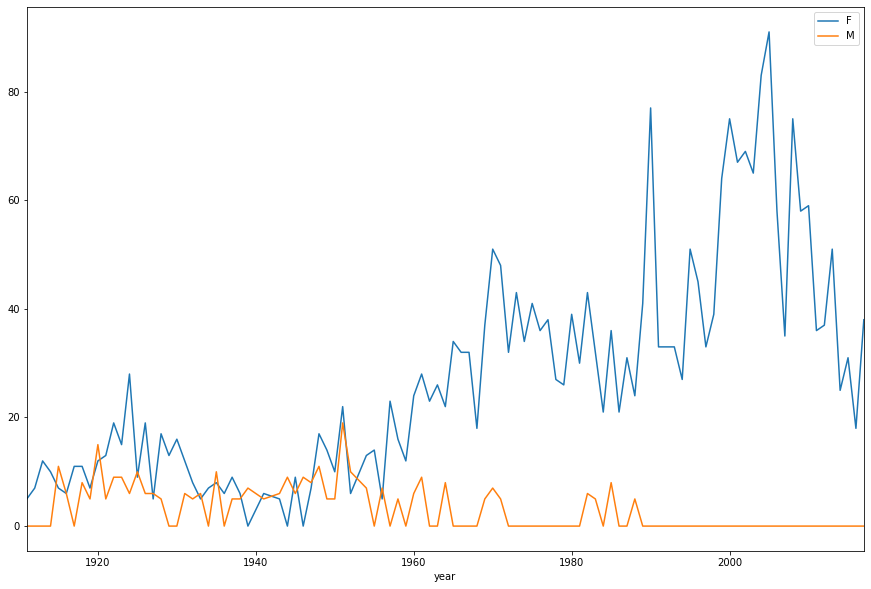

In [3]:
data = names.df[names.df.name == "Pilar"]
data = data.groupby(['year','sex']).sum().unstack().reset_index().fillna(0)
data.columns = ['year', 'F', 'M']
data = data.set_index('year')
data.plot(figsize=(15,10))

From the plot, we noticed that the name Pilar started to become a predominantly female name around the 1950s and continued to rise in its predominance throughout the next couple of decades - in fact, the number of babies named Pilar even grew over that timeframe. We found that in 1967, the book "One Hundred Years of Solitude" was published by Gabriel Garcia Marquez, a widely acclaimed Latin American author, in which Pilar was a name of a female character in the story. We assume that due to the popularity of the novel, prospective parents started to realize that Pilar was a befitting female name.

### Test all methods in BabyNames class

In [4]:
names=BabyNames('namesbystate/')

In [5]:
names=BabyNames('namesbystate/')

In [6]:
names.count(state='IL', year=2009)

135651

In [7]:
names.count()

308180519

In [8]:
names.Top10BabyNames(state='AL', year=2000)

Rank,Male,Female
1,William,Hannah
2,Jacob,Anna
3,Joshua,Madison
4,Christopher,Emily
5,Michael,Sarah
6,James,Alexis
7,John,Taylor
8,Matthew,Mary
9,Austin,Elizabeth
10,Tyler,Kayla


In [9]:
names.Top10BabyNames()

Rank,Male,Female
1,James,Mary
2,John,Patricia
3,Robert,Elizabeth
4,Michael,Jennifer
5,William,Linda
6,David,Barbara
7,Richard,Margaret
8,Joseph,Susan
9,Charles,Dorothy
10,Thomas,Jessica


In [10]:
names.ChangeOfPopularity(fromYear = 2014, toYear = 2015,top=10)

Names that increased in popularity:
 ['Kaiser', 'Bexley', 'Alaia', 'Riaan', 'Adaline', 'Meilani', 'Royalty', 'Aitana', 'Octavia', 'Charleston']
Names that decreased in popularity:
  ['Nevin', 'Female', 'Jessenia', 'Hala', 'Ethyn', 'Henrietta', 'Navaeh', 'Eldana', 'Jasen', 'Tayler']
Names having the same popularity (excluding names having no occurrences both in fromYear and toYear):
  ['Tilden', 'Lara', 'Adhya', 'Munira', 'Amery', 'Payden', 'Lavern', 'Anely', 'Arionna', 'Rosetta']


[['Kaiser',
  'Bexley',
  'Alaia',
  'Riaan',
  'Adaline',
  'Meilani',
  'Royalty',
  'Aitana',
  'Octavia',
  'Charleston'],
 ['Nevin',
  'Female',
  'Jessenia',
  'Hala',
  'Ethyn',
  'Henrietta',
  'Navaeh',
  'Eldana',
  'Jasen',
  'Tayler'],
 ['Tilden',
  'Lara',
  'Adhya',
  'Munira',
  'Amery',
  'Payden',
  'Lavern',
  'Anely',
  'Arionna',
  'Rosetta']]

In [11]:
names.Top5NamesPerYear(year = 2010, sex = 'F')

State,Rank 1,Num 1,Rank 2,Num 2,Rank 3,Num 3,Rank 4,Num 4,Rank 5,Num 5
AK,Sophia,62,Emma,51,Isabella,51,Olivia,44,Ava,33
AL,Emma,318,Isabella,254,Madison,251,Ava,218,Olivia,201
AR,Emma,202,Isabella,174,Addison,169,Chloe,139,Madison,137
AZ,Isabella,556,Sophia,516,Mia,376,Emma,336,Olivia,306
CA,Isabella,3366,Sophia,3360,Emily,2391,Mia,2016,Emma,1783
CO,Isabella,342,Sophia,317,Olivia,268,Emma,265,Abigail,245
CT,Isabella,278,Olivia,234,Sophia,231,Ava,192,Emma,192
DC,Madison,50,Olivia,43,Charlotte,37,Ashley,35,Ava,34
DE,Sophia,73,Isabella,66,Ava,64,Olivia,45,Emily,40
FL,Isabella,1837,Sophia,1248,Olivia,889,Emma,838,Emily,817


In [12]:
names.Top5NamesPerYear(year = 2012)

State,Rank 1,Num 1,Rank 2,Num 2,Rank 3,Num 3,Rank 4,Num 4,Rank 5,Num 5
AK,Emma,57,Sophia,56,James,52,Olivia,49,Ethan,47
AL,William,437,James,321,Emma,320,Mason,303,John,280
AR,William,217,Emma,186,Sophia,165,Mason,157,James,154
AZ,Sophia,589,Isabella,490,Emma,394,Jacob,393,Liam,382
CA,Sophia,3643,Isabella,3109,Jacob,2978,Jayden,2966,Daniel,2684
CO,Liam,355,Emma,337,Sophia,331,Olivia,317,Alexander,300
CT,Emma,246,Olivia,235,Isabella,234,Mason,230,Sophia,227
DC,William,94,Alexander,67,Henry,65,John,64,James,59
DE,Sophia,67,Isabella,65,Emma,63,Michael,60,Anthony,55
FL,Isabella,1586,Sophia,1374,Jayden,1193,Jacob,1080,Emma,1071


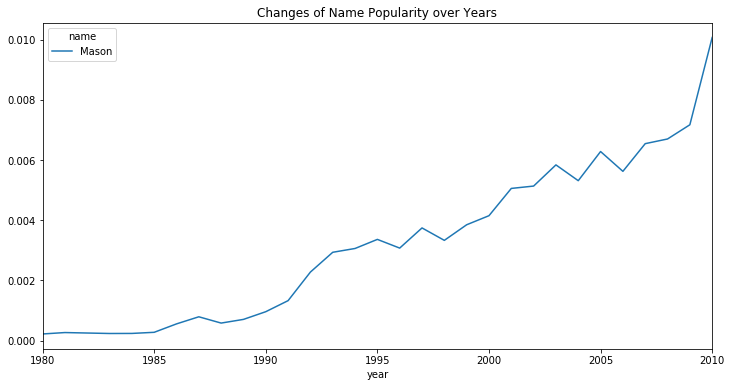

In [13]:
names.NamePopularityPlot(name = 'Mason', yearRange = (1980, 2010), state = 'AL', sex = 'M')

,name,flips
826,Natividad,28
705,Lorenza,28
902,Pilar,22


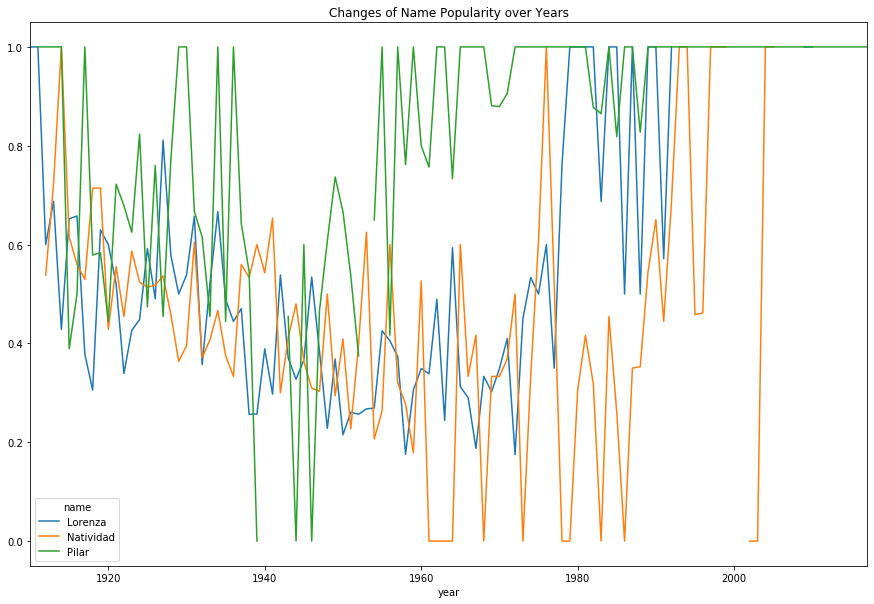

In [14]:
names.NameFlip(n=3)